In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import argparse
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy import ndimage
import imageio

2021-12-13 18:06:49.731385: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


# 이미지 전처리

In [ ]:
# train_path
train_yes_path = '/root/data/cut_data/clean/yes/*.jpg'
train_no_path = '/root/data/cut_data/clean/no/*.jpg'

# # test_path
# test_yes_path = '/root/data/cut_data/test/yes/*.jpg'
# test_no_path = '/root/data/cut_data/test/no/*.jpg'

# # val_path
# val_yes_path ='/root/data/cut_data/validation/yes/*.jpg'
# val_no_path ='/root/data/cut_data/validation/no/*.jpg'

In [ ]:
# 이미지 불러오기
# trian
train_yes = glob(train_yes_path)
train_no = glob(train_no_path)

# # test
# test_yes = glob(test_yes_path)
# test_no = glob(test_no_path)

# # validation
# val_yes = glob(val_yes_path)
# val_no = glob(val_no_path)

# 출력
print("train_yes=", len(train_yes))
print("train_no=", len(train_no))
# print("="*10)
# print("test_yes=", len(test_yes))
# print("test_no=", len(test_no))
# print("="*10)
# print("validation_yes=", len(val_yes))
# print("validation_no=", len(val_no))

## 이미지 증강

In [ ]:
!pip install --no-dependencies imgaug

In [ ]:
yes_img = glob('/root/data/cut_data/clean/yes/*.jpg')

In [ ]:
save_yes_folder = '/root/data/cut_data/yes_clean_aug/'

In [ ]:
no_img = glob('/root/data/cut_data/clean/no/*.jpg')

In [ ]:
save_no_folder = '/root/data/cut_data/no_clean_aug/'

In [2]:
TRAIN_DIR = '/root/data/cut_data/clean/'

In [3]:
IM_HEIGHT, IM_WIDTH = 128, 128

In [4]:
# 이미지를 증강하는 ImageGenerator 객체 생성
train_datagen = ImageDataGenerator(
    rescale = 1/255,
	rotation_range=30, # 이미지 회전 각도
    width_shift_range = 0.5,
    height_shift_range = 0.5,
	zoom_range=0.15, # 이미지 확대 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전
	fill_mode="nearest" # 이미지를 회전 이동시 빈공간을 채우는 방식
	)

In [5]:
train_generator = train_datagen.flow_from_directory(
                        TRAIN_DIR,
                        target_size=(IM_HEIGHT, IM_WIDTH),
                        batch_size=16,
                        class_mode="binary",
                        shuffle=True
                    )

Found 36885 images belonging to 2 classes.


In [ ]:
img,label = train_generator.next()

In [ ]:
# !pip install imageio
# import imageio
# for i in tqdm(range(len(yes_img))):
#     image_path = yes_img[i]
#     image = np.expand_dims(imageio.imread(image_path), 0)

#     #원본 이미지를 맞춥니다.
#     datagen.fit(image)
  
#     #이미지를 반복하고 "save_to_dir" 매개변수를 사용하여 저장
#     for x, val in zip(datagen.flow(image,                    #image we chose
#                               save_to_dir=save_yes_folder,     #this is where we figure out where to save
#                               save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
#                               save_format='jpg'),range(10)) :
#         pass     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think

    
# for i in tqdm(range(len(no_img))):
#     image_path = no_img[i]
#     image = np.expand_dims(imageio.imread(image_path), 0)

#     #원본 이미지를 맞춥니다.
#     datagen.fit(image)
  
#     #이미지를 반복하고 "save_to_dir" 매개변수를 사용하여 저장
#     for x, val in zip(datagen.flow(image,                    #image we chose
#                               save_to_dir=save_no_folder,     #this is where we figure out where to save
#                               save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
#                               save_format='jpg'),range(10)) :
#         pass     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think


## 이미지 갯수 비율 맞추기

In [ ]:
# 이미지 개수 비율 맞추기
def image_ratio(yes, no):
    min_num = min(len(yes),len(no))
    return yes[0:min_num], no[0:min_num]

In [ ]:
train_yes = glob('/root/data/cut_data/yes_clean_aug/*.jpg')

In [ ]:
# 함수 실행
train_yes , train_no = image_ratio(train_yes, train_no)
# test_yes , test_no = image_ratio(test_yes, test_no)
# val_yes , val_no = image_ratio(val_yes, val_no)

# 출력
print("train_yes=", len(train_yes))
print("train_no=", len(train_no))
# print("="*10)
# print("test_yes=", len(test_yes))
# print("test_no=", len(test_no))
# print("="*10)
# print("validation_yes=", len(val_yes))
# print("validation_no=", len(val_no))

## img_to_array

In [ ]:
data_list = []
label_list = []

# image 변환 및 라벨 생성
def image_preprocessing(path, data_list, label_list, label_num):
    label = label_list
    data = data_list
    for i in tqdm(path):
        try:
            image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
            target_size= (128,128)
                                                 )
            image = np.array(image)
            data.append(image)
            label.append(label_num)
        except:
            print(i)

    return  data, label

In [ ]:
data, label = image_preprocessing(train_yes, data_list, label_list, 1)
# data, label = image_preprocessing(test_yes, data, label, 1)
data, label = image_preprocessing(train_no, data, label, 0)
# data, label = image_preprocessing(test_no, data, label, 0)

data = np.array(data, dtype=np.float32)/255
label = np.array(label)

In [ ]:
data.shape

In [ ]:
# validation set
X_val, y_val = image_preprocessing(val_yes, data_list, label_list, 1)
X_val, y_val = image_preprocessing(val_no, X_val, y_val, 0)

X_val = np.array(X_val, dtype=np.float32)/255
y_val = np.array(y_val)
y_val = to_categorical(y_val)

In [ ]:
label_list[0]

In [ ]:
label[0]

In [ ]:
label[0]

In [ ]:
print(X_val.shape)
print(y_val.shape)

In [ ]:
np.save('/root/data/cut_data/clean_X_data.npy', data) # x_save.npy
np.save('/root/data/cut_data/clean_X_label.npy', label) # x_save.npy
# np.save('/root/data/jun/jun_label_val_x.npy', X_val)
# np.save('/root/data/jun/jun_label_val_y.npy', y_val)

# 데이터 로드 -> 학습

In [ ]:
data = np.load('/root/data/cut_data/clean_X_data.npy')
label = np.load('/root/data/cut_data/clean_X_label.npy')
# X_val = np.load('/root/data/jun/jun_label_val_x.npy')
# y_val = np.load('/root/data/jun/jun_label_val_y.npy')

In [ ]:
# 인코딩
label = to_categorical(label)
print(label.shape)

In [ ]:
# train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)

In [ ]:
print("X_train.shape =",X_train.shape)
print("X_test.shape =",X_val.shape)
print("y_train.shape =",y_train.shape)
print("y_train.shape =",y_val.shape)

In [ ]:
# import gc
# tf.keras.backend.clear_session()
# gc.collect()

## 모델 로드 ,컴파일, 학습

In [6]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(128, 128, 3), input_tensor=Input(shape=(128, 128, 3)))

    # construct the head of the model that will be placed on top of the
    # the base model

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(32, activation="relu")(headModel)
    headModel = Dense(2, activation="softmax")(headModel)

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)

    model = Model(inputs=baseModel.input, outputs=headModel)

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process

    baseModel.trainable = False

    model.compile(
        loss = 'sparse_categorical_crossentropy',  #binary_crossentropy
        optimizer = Adam(learning_rate = 1e-5),
        metrics = ['acc']
                  )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-12-13 18:07:15.411280: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-13 18:07:15.488079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 18:07:15.488969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-13 18:07:15.489050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 18:07:15.489900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 00

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:
model.summary()

In [7]:
# checkpoint 만들기
checkpoint_path = '/root/data/cut_data/cut_mobile_model2/tmp_checkpoint.ckpt'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path
    ,save_weights_only=True
    ,save_best_only=True
    ,monitor='acc' # val_loss
    ,verbose=1
)

In [18]:
model.compile(
        loss = 'sparse_categorical_crossentropy',  #binary_crossentropy
        optimizer = Adam(learning_rate = 1e-5),
        metrics = ['acc']
                  )

In [19]:
# 모델 학습
hist = model.fit(train_generator, 
                 epochs = 100, 
                 batch_size = 16, 
                 callbacks=[checkpoint])

Epoch 1/100
2306/2306 [==============================] - ETA: 0s - loss: 0.3464 - acc: 0.8439
Epoch 00001: acc did not improve from 0.84896
2306/2306 [==============================] - 141s 61ms/step - loss: 0.3464 - acc: 0.8439
Epoch 2/100
2306/2306 [==============================] - ETA: 0s - loss: 0.3405 - acc: 0.8479
Epoch 00002: acc did not improve from 0.84896
2306/2306 [==============================] - 142s 61ms/step - loss: 0.3405 - acc: 0.8479
Epoch 3/100
2305/2306 [============================>.] - ETA: 0s - loss: 0.3434 - acc: 0.8455
Epoch 00003: acc did not improve from 0.84896
2306/2306 [==============================] - 142s 62ms/step - loss: 0.3434 - acc: 0.8455
Epoch 4/100
2306/2306 [==============================] - ETA: 0s - loss: 0.3384 - acc: 0.8478
Epoch 00004: acc did not improve from 0.84896
2306/2306 [==============================] - 141s 61ms/step - loss: 0.3384 - acc: 0.8478
Epoch 5/100
2306/2306 [==============================] - ETA: 0s - loss: 0.3394 - ac

In [20]:
model.save('/root/data/model/cut_mobile_model2/mobilenetv2_epoch150.h5')

In [21]:
model.load_weights(checkpoint_path)

In [22]:
model.save('/root/data/model/cut_mobile_model2/mobilenetv2_best_acc_epoch150.h5')

In [23]:
# 이미지를 증강하는 ImageGenerator 객체 생성
test_datagen = ImageDataGenerator(
    rescale = 1/255
	)

In [27]:
TEST_DIR = '/root/data/jun/custom_frame/'

In [28]:
test_generator = test_datagen.flow_from_directory(
                        TEST_DIR,
                        target_size=(IM_HEIGHT, IM_WIDTH),
                        batch_size=16,
                        class_mode="binary",
                        shuffle=True
                    )

Found 160673 images belonging to 2 classes.


In [34]:
model = tf.keras.models.load_model("/root/data/model/cut_mobile_model/mobilenetv2_best_acc1213.h5")

In [ ]:
model.evaluate(test_generator)

 2860/10043 [=======>......................] - ETA: 51:23 - loss: 0.4737 - acc: 0.7703

In [24]:
from tensorflow import keras
model = keras.models.load_model('/root/data/model/cut_mobile_model2/mobilenetv2_best_acc_epoch150.h5', compile=False)

export_path = '/root/data/model/cut_mobile_model_epoch150/pb'
model.save(export_path, save_format="tf")

INFO:tensorflow:Assets written to: /root/data/model/cut_mobile_model_epoch150/pb/assets


INFO:tensorflow:Assets written to: /root/data/model/cut_mobile_model_epoch150/pb/assets


In [25]:
import tensorflow as tf

saved_model_dir = '/root/data/model/cut_mobile_model_epoch150/pb'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open('/root/data/model/cut_mobile_model_epoch150/tf/converted_model.tflite', 'wb').write(tflite_model)

2021-12-14 02:22:25.211811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 02:22:25.212181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 02:22:25.212532: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2021-12-14 02:22:25.212628: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-12-14 02:22:25.213024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 02:22:25.213262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found

9560556

## 학습과load_weights화

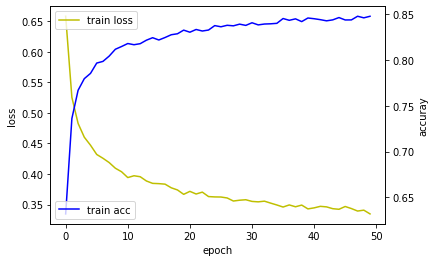

In [18]:
# 학습과정 표시
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

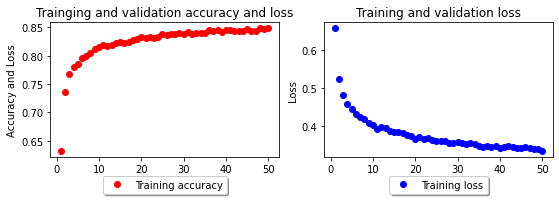

In [17]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    # val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    # val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(9, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    # plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()
show_graph(hist.history)

In [ ]:
X_test[0].shape

In [ ]:
model.evaluate(X_test[:15],y_test[:15])

In [ ]:
model.predict(X_test[:5])

In [ ]:
plt.imshow(X_test[2])
print(y_test[2])

In [ ]:
plt.imshow(X_test[3])
print(y_test[3])

In [ ]:
glob('/root/data/jun/yes_frame/*jpg')[0]

In [ ]:
image = tf.keras.preprocessing.image.load_img('/root/data/jun/yes_frame/33968.jpg', color_mode='rgb', target_size= (128,128))
image = np.array(image)
image = np.reshape(image, (-1, 128, 128, 3))
model.predict(image)

In [ ]:
glob('/root/data/jun/no_frame/*jpg')[0]

In [ ]:
image = tf.keras.preprocessing.image.load_img('/root/data/jun/no_frame/55283.jpg', color_mode='rgb', target_size= (128,128))
image = np.array(image)
image = np.reshape(image, (-1, 128, 128, 3))
model.predict(image)

In [ ]:
%cd /root/data/cut_data/RetinaFace-tf2

In [ ]:
from src.retinafacetf2.retinaface import RetinaFace
import cv2
from tqdm import tqdm
import os
import random

detector = RetinaFace(False, 0.4)

In [ ]:
base_path = '/root/data/jun/'

for yn in ['no_frame', 'yes_frame']:
    i = 0
    j = 0
    for img_path in tqdm(random.shuffle(glob(base_path + yn + '/' +'*jpg'))):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            faces, landmarks = detector.detect(img, 0.8)

            if yn == 'yes_frame':
                for idx in range(faces.shape[0]):
                    x ,y , xw, yh = faces[idx][:4]
                    x ,y , xw, yh = faces[idx][:4]
                    w = xw - x
                    h = yh - y
                    x_min = max(0, int(x - 0.5 * w))
                    y_min = max(0, int(y - 0.6 * h))
                    x_max = min(img.shape[1], int(x + 1.5 * w))
                    y_max = min(img.shape[0], int(y + 1.3 * h))

                    face_img = img[y_min:y_max, x_min:x_max]

                    cv2.imwrite(f'/root/data/cut_custom_data/yes/{i}.jpg', face_img)
                    i += 1
                if i == 1000:
                    break
            else:
                for idx in range(faces.shape[0]):
                    x ,y , xw, yh = faces[idx][:4]
                    x ,y , xw, yh = faces[idx][:4]
                    w = xw - x
                    h = yh - y
                    x_min = max(0, int(x - 0.5 * w))
                    y_min = max(0, int(y - 0.6 * h))
                    x_max = min(img.shape[1], int(x + 1.5 * w))
                    y_max = min(img.shape[0], int(y + 1.3 * h))

                    face_img = img[y_min:y_max, x_min:x_max]

                    cv2.imwrite(f'/root/data/cut_custom_data/no/{j}.jpg', face_img)
                    j += 1
                if j ==1000:
                    break
        except:
            print(img_path)

In [ ]:
model = tf.keras.models.load_model("/root/data/model/cut_mobile_model/mobilenetv2_best_val_loss1126.h5")

In [ ]:
glob('/root/data/cut_custom_data/yes/*.jpg')[0]

In [ ]:
image = tf.keras.preprocessing.image.load_img('/root/data/cut_custom_data/yes/14.jpg', color_mode='rgb', target_size= (128,128))
image = np.array(image)
image = np.reshape(image, (-1, 128, 128, 3))
model.predict(image)

In [ ]:
image = tf.keras.preprocessing.image.load_img('/root/data/cut_custom_data/no/14.jpg', color_mode='rgb', target_size= (128,128))
image = np.array(image)
image = np.reshape(image, (-1, 128, 128, 3))
model.predict(image)

In [ ]:
score = 0
for img in glob('/root/data/cut_custom_data/yes/*.jpg'):
    image = tf.keras.preprocessing.image.load_img(img, color_mode='rgb', target_size= (128,128))
    image = np.array(image)
    image = np.reshape(image, (-1, 128, 128, 3))
    pred = model.predict(image)[0]
    if pred[1] >= 0.5:
        score += 1

print(score)

In [ ]:
score = 0
for img in glob('/root/data/cut_custom_data/no/*.jpg'):
    image = tf.keras.preprocessing.image.load_img(img, color_mode='rgb', target_size= (128,128))
    image = np.array(image)
    image = np.reshape(image, (-1, 128, 128, 3))
    pred = model.predict(image)[0]
    if pred[0] > 0.5:
        score += 1
print(score)